# ERC Risk Premia Portfolio Backtest

In this notebook we backtest a more advanced risk parity long-only portfolio of ETFs.

Review the basic riskpremia notebook in this directory first.

In [1]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import ffn

%matplotlib inline

# Hack to ensure the notebook can load local modules by appending the parent directory to the system path
# Ensure a '.env' file is in the workspace root so location can be detected
from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv('donotdelete.env')))

import alphasim.backtest
importlib.reload(alphasim.backtest)
from alphasim.backtest import backtest

import alphasim.stats
importlib.reload(alphasim.stats)
from alphasim.stats import calc_stats, calc_log_returns, calc_rolling_ann_vola


In [2]:
price_df = pdr.get_data_yahoo(['VTI', 'TLT', 'GLD'], start='2000-01-01').dropna()
price_df = price_df['Adj Close']
display(price_df)

Symbols,VTI,TLT,GLD
Date,,,
2004-11-18,41.046688,50.798885,44.380001
2004-11-19,40.548519,50.393547,44.779999
2004-11-22,40.815395,50.656128,44.950001
2004-11-23,40.829617,50.719002,44.750000
2004-11-24,41.064476,50.719002,45.049999
...,...,...,...
2022-10-03,184.029999,103.830002,158.429993
2022-10-04,189.940002,103.540001,160.699997
2022-10-05,189.580002,102.550003,159.809998


## ERC Weights

Define weights based on the rolling co-variance and the equal risk contribution (ERC) algorithm.

In [3]:
# Sensible EWMA alphas
ewma_vol_alpha = 1.-0.94
ewma_cov_alpha = 1.-0.975

ret_df = np.log(price_df/price_df.shift(1)).dropna()
cumret_df = ret_df.cumsum()
vola_df = ret_df.ewm(alpha=ewma_vol_alpha, adjust=False).std() * np.sqrt(252)
cov_df = ret_df.ewm(alpha=ewma_cov_alpha, adjust=False).cov().dropna()

cov_mat = cov_df.groupby('Date').apply(lambda x: x.values)

In [4]:
risk_budget = np.array([1,1,1])

weight_df = ret_df[1:].copy()
weight_df[:] = 0

initial_weights = np.array([1,1,1])

#weight_df = ffn.core._erc_weights_ccd(
   #     initial_weights, cov=cov_mat_df, b=risk_budget, maximum_iterations=1000, tolerance=1e-8)

for i in range(len(weight_df)):

    try:
        w = ffn.core._erc_weights_ccd(
            initial_weights, cov=cov_mat[i], b=risk_budget, maximum_iterations=1000, tolerance=1e-8)
    except:
        w = np.NAN
    
    weight_df.iloc[i] = w

weight_df = weight_df.fillna(method="ffill")
weight_df = weight_df.fillna(method="bfill")

display(weight_df * 100)

/Users/richklee/repos/github.com/richklee/alphasim/venv/lib/python3.10/site-packages/ffn/core.py:1739: RuntimeWarning: invalid value encountered in sqrt
  sigma_x = np.sqrt(


Symbols,VTI,TLT,GLD
Date,,,
2004-11-22,18.431074,24.904798,56.664128
2004-11-23,18.431074,24.904798,56.664128
2004-11-24,18.431074,24.904798,56.664128
2004-11-26,18.431074,24.904798,56.664128
2004-11-29,18.431074,24.904798,56.664128
...,...,...,...
2022-10-03,27.687296,31.596091,40.716612
2022-10-04,26.732673,33.003300,40.264026
2022-10-05,26.885246,32.786885,40.327869


In [5]:
def fixed_min_commission(trade_price, trade_size):
    return 10

result = backtest(
    prices=price_df[2:], 
    weights=weight_df, 
    trade_buffer=0.04, 
    do_limit_trade_size=False, 
    commission_func=fixed_min_commission,
    initial_capital=10000,
    do_reinvest=True)

display(result)

price  start_portfolio        equity  current_weight  \
datetime   Symbols                                                              
2004-11-22 VTI       40.815395         0.000000      0.000000        0.000000   
           TLT       50.656128         0.000000      0.000000        0.000000   
           GLD       44.950001         0.000000      0.000000        0.000000   
           cash       1.000000     10000.000000  10000.000000        1.000000   
2004-11-23 VTI       40.829617        45.157161   1843.749576        0.185329   
...                        ...              ...           ...             ...   
2022-10-06 cash       1.000000       183.206600    183.206600        0.005544   
2022-10-07 VTI      182.399994        43.907888   8008.798509        0.246006   
           TLT      100.989998       102.866149  10388.452179        0.319102   
           GLD      157.880005        88.515722  13974.862639        0.429265   
           cash       1.000000       183.206600    183.206600        0.005628   

                    target_weight  delta_weight  do_trade  adj_target_weight  \
datetime   Symbols                                                             
2004-11-22 VTI           0.184311      0.184311      True           0.184311   
           TLT           0.249048      0.249048      True           0.249048   
           GLD           0.566641      0.566641      True           0.566641   
           cash          0.000000     -1.000000     False           1.000000   
2004-11-23 VTI           0.184311     -0.001018     False           0.185329   
...                           ...           ...       ...                ...   
2022-10-06 cash          0.000000     -0.005544     False           0.005544   
2022-10-07 VTI           0.263158      0.017152     False           0.246006   
           TLT           0.332237      0.013135     False           0.319102   
           GLD           0.404605     -0.024660     False           0.429265   
           cash          0.000000     -0.005628     False           0.005628   

                    adj_delta_weight  trade_value  trade_size  commission  \
datetime   Symbols                                                          
2004-11-22 VTI              0.184311  1843.107388   45.157161        10.0   
           TLT              0.249048  2490.479817   49.164433        10.0   
           GLD              0.566641  5666.412795  126.060349        10.0   
           cash             0.000000     0.000000    0.000000         0.0   
2004-11-23 VTI              0.000000     0.000000    0.000000         0.0   
...                              ...          ...         ...         ...   
2022-10-06 cash             0.000000     0.000000    0.000000         0.0   
2022-10-07 VTI              0.000000     0.000000    0.000000         0.0   
           TLT              0.000000     0.000000    0.000000         0.0   
           GLD              0.000000     0.000000    0.000000         0.0   
           cash             0.000000     0.000000    0.000000         0.0   

                    end_portfolio  
datetime   Symbols                 
2004-11-22 VTI          45.157161  
           TLT          49.164433  
           GLD         126.060349  
           cash        -30.000000  
2004-11-23 VTI          45.157161  
...                           ...  
2022-10-06 cash        183.206600  
2022-10-07 VTI          43.907888  
           TLT         102.866149  
           GLD          88.515722  
           cash        183.206600  

[18004 rows x 13 columns]

In [6]:
trades_df = result.loc[result['do_trade'] == True]
display(len(trades_df))
display(trades_df.tail(5))

293

price  start_portfolio        equity  current_weight  \
datetime   Symbols                                                              
2022-03-08 GLD      191.509995        87.916838  16836.953178        0.421311   
2022-04-29 VTI      205.185242        59.347817  12177.296112        0.328656   
           GLD      176.910004        79.378191  14042.796018        0.379004   
2022-06-03 TLT      115.072121        89.084086  10251.094654        0.282162   
2022-09-13 VTI      196.933929        50.878632  10019.728999        0.295370   

                    target_weight  delta_weight  do_trade  adj_target_weight  \
datetime   Symbols                                                             
2022-03-08 GLD           0.380392     -0.040918      True           0.380392   
2022-04-29 VTI           0.281755     -0.046901      True           0.281755   
           GLD           0.422633      0.043629      True           0.422633   
2022-06-03 TLT           0.325815      0.043653      True           0.325815   
2022-09-13 VTI           0.254902     -0.040468      True           0.254902   

                    adj_delta_weight  trade_value  trade_size  commission  \
datetime   Symbols                                                          
2022-03-08 GLD             -0.040918 -1635.236301   -8.538647        10.0   
2022-04-29 VTI             -0.046901 -1737.751630   -8.469184        10.0   
           GLD              0.043629  1616.520705    9.137531        10.0   
2022-06-03 TLT              0.043653  1585.931269   13.782063        10.0   
2022-09-13 VTI             -0.040468 -1372.776075   -6.970744        10.0   

                    end_portfolio  
datetime   Symbols                 
2022-03-08 GLD          79.378191  
2022-04-29 VTI          50.878632  
           GLD          88.515722  
2022-06-03 TLT         102.866149  
2022-09-13 VTI          43.907888

In [7]:
stats = calc_stats(result)
display(stats)

,equity
start,2004-11-22 00:00:00
end,2022-10-07 00:00:00
rf,0.0
total_return,2.255532
cagr,0.068272
max_drawdown,-0.223549
calmar,0.305401
mtd,0.008916
three_month,-0.061253
six_month,-0.165963


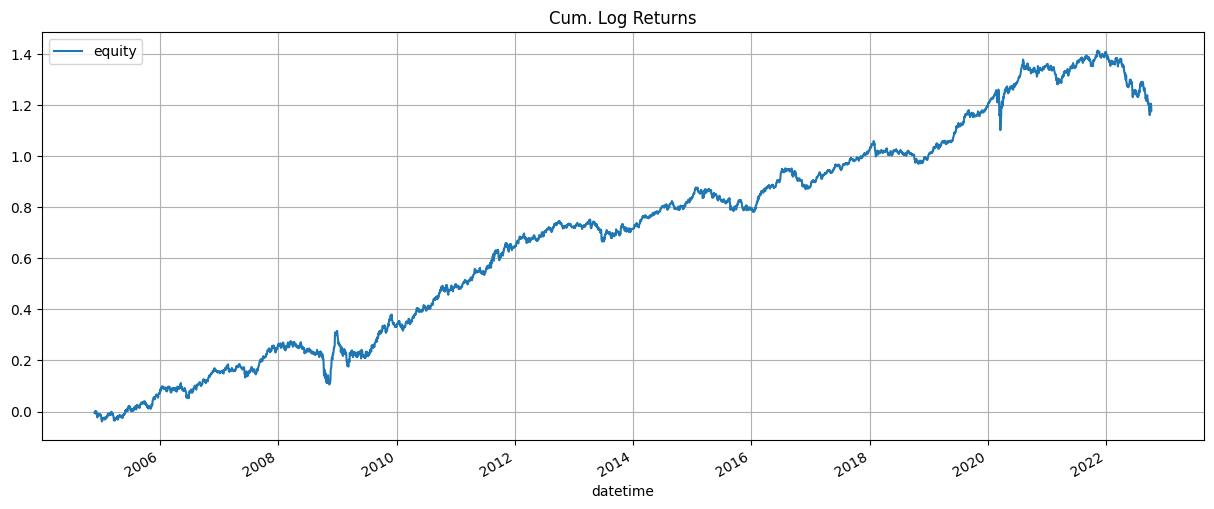

In [8]:
ax = calc_log_returns(result).cumsum().plot(figsize=(15, 6))
ax.grid(True)
plt.title('Cum. Log Returns')
plt.legend(loc=2)
plt.show()

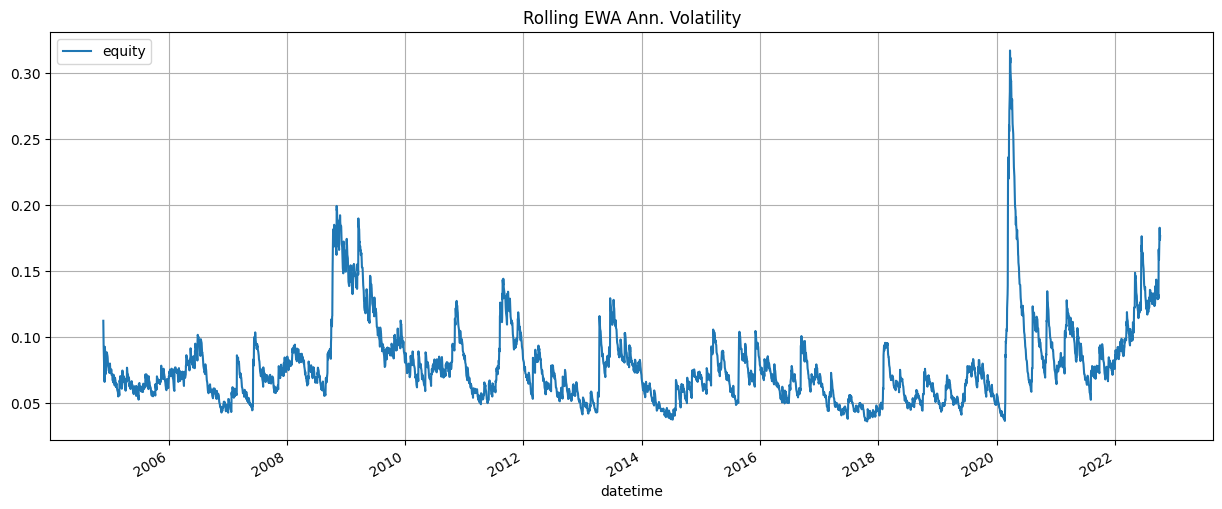

In [9]:
ax = calc_rolling_ann_vola(result).plot(figsize=(15, 6))
ax.grid(True)
plt.title('Rolling EWA Ann. Volatility')
plt.legend(loc=2)
plt.show()